<a href="https://colab.research.google.com/github/MattiaCarolo/robe/blob/master/UDA_Coral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center> Unsupervised Domain Adaptation </center>
###### <center> through </center>
#<center> Geodesic Distance Minimization & Pseudo-Labeling Refinement Steps </center>
---



## Utility imports


In [ ]:
from os import listdir, path, mkdir
import shutil
from tqdm import tqdm
import torch
import torch.nn as nn
from IPython.display import display_html
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torch import Tensor
from torch.utils.tensorboard import SummaryWriter
import random
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import plotly.express as px
from plotly.io import write_image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.colors import rgb2hex
from PIL import Image, ImageOps
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
from torchvision import datasets, transforms, models
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# typing
from typing import Dict, Iterable, Callable, Tuple, Any, List
import colorsys

torch.manual_seed(5)
random.seed(5)
np.random.seed(5)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun  7 13:03:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Constants

In [ ]:
NUM_CLASSES = 20
BATCH_SIZE = 64
device = 'cuda:0'
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.000001
MOMENTUM = 0.9
EPOCHS = 40

PATH = "/content/gdrive/MyDrive/Colabber/" # Path in which the Adaptiope.zip is contained.
                                             # This path will also contain, at the end of the execution of this script,
                                             # the models of the networks, the unzipped version of the dataset and the final results


<br/>

### Mounting of the Google Drive folder and creation of the needed folders



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Folder for the results
if not path.exists(path.join(PATH, "Results/")):
    mkdir(path.join(PATH, "Results/"))

# Folder for the models of the networks
if not path.exists(path.join(PATH, "Models/")):
    mkdir(path.join(PATH, "Models/"))

# Folder for the dataset
if not path.exists(path.join(PATH, "Datasets/")):
    mkdir(path.join(PATH, "Datasets/"))

# Nuova sezione

In [ ]:
# Unzip the dataset

# RUN ONLY THE FIRST TIME U SETUP THE ENVIRONMENT


p = path.join(PATH, "Datasets/")
z = path.join(PATH, "Adaptiope.zip")

# Toggle comment on first run

#!rm -rf "$p"
#!unzip -q "$z" -d "$p"

In [ ]:
# Creation of the reduced version of the dataset
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet",
           "flat iron", "game controller", "glasses", "helicopter", "ice skates",
           "letter tray", "monitor", "mug", "network switch", "over-ear headphones",
           "pen", "purse", "stand mixer", "stroller"]

# Product images
for category in tqdm(listdir(path.join(p, "Adaptiope/product_images"))):
  if category not in set(classes):
    shutil.rmtree(path.join(p, "Adaptiope/product_images/", category))

# Real life images
for category in tqdm(listdir(path.join(p, "Adaptiope/real_life"))):
  if category not in set(classes):
    shutil.rmtree(path.join(p, "Adaptiope/real_life/", category))

# Removal of synthetic images
if "synthetic" in set(listdir(path.join(p, "Adaptiope"))):
  shutil.rmtree(path.join(p, "Adaptiope/synthetic"))

100%|██████████| 20/20 [00:00<00:00, 108801.66it/s]


## Dataloaders

In [ ]:
"""
Function that instantiates the dataloaders of the training and test sets

:param batch_size: mini batch size used during training
:param img_root: path to the dataset parent folder
:return train_loader, test_loader, stat_loader, imL: train loader, test loader,
                                                     loader for the final analysis and list of tuple (path_to_image, class)

"""

def get_data(batch_size, img_root):

  # Prepare data transformations for the dataloaders
  transform = list()
  transform.append(T.Resize((256, 256)))
  transform.append(T.RandomCrop((224, 224)))
  transform.append(T.ToTensor())
  transform.append(T.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]))
  transform = T.Compose(transform)

  # Load data
  adaptiope_dataset = torchvision.datasets.ImageFolder(root=img_root, transform=transform)

  # Creation of the list of tuple (path_to_image, class)
  imL = []
  for img in adaptiope_dataset.imgs:
    imL.append((img[0], img[1]))

  # Create train and test splits (80/20)
  num_samples = len(adaptiope_dataset)
  training_samples = int(num_samples * 0.8 + 1)
  test_samples = num_samples - training_samples

  training_data, test_data = torch.utils.data.random_split(adaptiope_dataset,
                                                           [training_samples, test_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True, drop_last = True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False, drop_last = True)
  stat_loader = torch.utils.data.DataLoader(adaptiope_dataset, shuffle=False)

  return train_loader, test_loader, stat_loader, imL, adaptiope_dataset.class_to_idx

In [ ]:
train_loader_product, test_loader_product, stat_product_loader, imLProduct, class_mapping = get_data(batch_size = BATCH_SIZE, img_root = path.join(p, "Adaptiope/product_images"))
train_loader_realworld, test_loader_realworld, stat_rw_loader, imLRW, class_mapping = get_data(batch_size = BATCH_SIZE, img_root = path.join(p, "Adaptiope/real_life"))

## Plotting
This section contains plotting functions for error analysis. In particular we plot:

* TSNE It uses the t-distributed stochastic neighbour embedding. https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding


<!---${\displaystyle p_{j\mid i}={\frac{\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{j}\rVert ^{2}/2\sigma _{i}^{2})}{\sum _{k\neq i}\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{k}\rVert ^{2}/2\sigma _{i}^{2})}}}$

${\displaystyle p_{ij}={\frac {p_{j\mid i}+p_{i\mid j}}{2N}}}$

${\displaystyle q_{ij}={\frac {(1+\lVert \mathbf {y} _{i}-\mathbf {y} _{j}\rVert ^{2})^{-1}}{\sum _{k}\sum _{l\neq k}(1+\lVert \mathbf {y} _{k}-\mathbf {y} _{l}\rVert ^{2})^{-1}}}}$

${\displaystyle \mathrm {KL} \left(P\parallel Q\right)=\sum _{i\neq j}p_{ij}\log {\frac {p_{ij}}{q_{ij}}}}$--->

* Confusion matrixes
* Confidence for class prediction

In [ ]:
def ref_labels(loader: Iterable) -> Iterable:
    data = []
    for i in loader:
        data.append(i[1])
    return np.concatenate(data,axis=0)

In [ ]:
def color_map(class_labels: Dict[str,int]) -> Dict[int,Tuple[int,int,int]]:
    colormap = {}
    for k,i in class_labels.items():
        i = i/len(class_labels)
        (h, s, v) = (0.0+i, 0.5, 1)
        (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
        colormap[int (i * len(class_labels))] = (round(r,2),round(g,2),round(b,2))
    return colormap

In [ ]:
def color(labels: Iterable[str], colormap: Dict[int,Tuple[int,int,int]]) -> Iterable[Tuple[int,int,int]]:
    colors = []
    for i in labels:
        colors.append(colormap[i])
    return colors

In [ ]:
colormap = color_map(class_mapping)

## Losses


In [ ]:
#@title Criterions
def get_ce_loss() -> nn.Module:
    return nn.CrossEntropyLoss()
def get_bce_loss() -> nn.Module:
    return nn.BCEWithLogitsLoss()

## Test step


In [ ]:
#@title Test step
def test_step(
        extractor: nn.Module,
        classifier: nn.Module,
        data_loader: Iterable,
        cost_function: nn.Module,
        device='cuda:0',
        features: Iterable[str] = None,
        net_outputs: bool = False) -> Tuple[float,float] or Tuple[float,float,Iterable[Tensor]] or Tuple[float,float,Iterable[Tensor],Iterable[Tensor]]:

    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.
    # set the network to evaluation mode
    extractor.eval()
    classifier.eval()
    # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
    embeddings = []
    outs = []
    with torch.no_grad():
        # iterate over the test set
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            # load data into GPU
            inputs = inputs.to(device)
            targets = targets.to(device)
            # forward pass
            if features:
                extracted = extractor(inputs)
                outputs,emb = classifier(extracted,features)
                for id,e in enumerate(emb):
                    if batch_idx==0:
                        embeddings.append(e)
                    else:
                        embeddings[id] = torch.cat([embeddings[id],e],dim=0)
            else:
                extracted = extractor(inputs)
                outputs = classifier(extracted)
            # loss computation
            loss = cost_function(outputs, targets)
            # fetch prediction and loss value
            samples+=inputs.shape[0]
            cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
            _, predicted = outputs.max(1)
            # compute accuracy
            cumulative_accuracy += predicted.eq(targets).sum().item()
            outputs = torch.argmax(outputs,dim=1)
            outs.append(outputs)
    outs = torch.cat(outs,dim=0)
    if features:
        if net_outputs:
            return float(cumulative_loss/samples), float(cumulative_accuracy/samples*100),embeddings,outs
        else:
            return float(cumulative_loss/samples), float(cumulative_accuracy/samples*100),embeddings
    else:
        if net_outputs:
            return float(cumulative_loss/samples), float(cumulative_accuracy/samples*100),outs
        else:
            return float(cumulative_loss/samples), float(cumulative_accuracy/samples*100)

## Optimizer

In [ ]:

def get_optimizer(model: nn.Module, lr: float, wd: float):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    return optimizer

def get_optimizer_params_list(params: List[Any], lr: float, wd: float):
    optimizer = torch.optim.Adam(params, lr=lr, weight_decay=wd)
    return optimizer

# used bu Self-Supervision UDA
def get_optimizer_ext_head(models_params: Tuple[nn.Module, nn.Module], lr: float, wd: float):
    extractor_params, head_params = models_params[0], models_params[1]
    # assign the distinct learning rates to each group of parameters
    optimizer = torch.optim.Adam([
        {'params': extractor_params},
        {'params': head_params, 'lr': lr}
    ], lr=lr / 10, weight_decay=wd)
    return optimizer

## Weight init

In [ ]:
def init_weights(model: nn.Module) -> None:
    classname = model.__class__.__name__
    if classname.find('Conv2d') != -1 or classname.find('ConvTranspose2d') != -1:
        nn.init.kaiming_uniform_(model.weight)
        nn.init.zeros_(model.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal(model.weight, 1.0, 0.02)
        nn.init.zeros_(model.bias)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(model.weight)
        nn.init.zeros_(model.bias)

# Source-only scenario

Here we start from a test a simple ResNET18 without domain adaptation to get a baseline to compare the results.

We train the model using a simple Cross Entropy Loss.

$CE = -\sum\limits_{i}\limits^{M} y_i log(p(y_i)) $
where $M$ is the number of classes

In [ ]:
def get_ce_loss() -> nn.Module:
    return nn.CrossEntropyLoss()

## Temp

In [ ]:
## pretrained models file names for saving or loading to save time.

# source only
resnet18_ex_r_path = "resnet18_ex_r.pth"
resnet18_cl_r_path = "resnet18_cl_r.pth"
resnet18_ex_p_path = "resnet18_ex_p.pth"
resnet18_cl_p_path = "resnet18_cl_p.pth"

#background removal
resnet18_ex_foreground_r_path = "resnet18_ex_foreground_r.pth"
resnet18_cl_foreground_r_path = "resnet18_cl_foreground_r.pth"
resnet18_ex_foreground_p_path = "resnet18_ex_foreground_p.pth"
resnet18_cl_foreground_p_path = "resnet18_cl_foreground_p.pth"

# mmd loss
resnet18_ex_mmd_r_p_path = "resnet18_ex_mmd_r_p.pth"
resnet18_cl_mmd_r_p_path = "resnet18_cl_mmd_r_p.pth"
resnet18_ex_mmd_p_r_path = "resnet18_ex_mmd_p_r.pth"
resnet18_cl_mmd_p_r_path = "resnet18_cl_mmd_p_r.pth"

# coral loss
resnet18_ex_coral_r_p_path = "resnet18_ex_coral_r_p.pth"
resnet18_cl_coral_r_p_path = "resnet18_cl_coral_r_p.pth"
resnet18_ex_coral_p_r_path = "resnet18_ex_coral_p_r.pth"
resnet18_cl_coral_p_r_path = "resnet18_cl_coral_p_r.pth"

# lmmd loss
resnet18_ex_lmmd_r_p_path = "resnet18_ex_lmmd_r_p.pth"
resnet18_cl_lmmd_r_p_path = "resnet18_cl_lmmd_r_p.pth"
resnet18_ex_lmmd_p_r_path = "resnet18_ex_lmmd_p_r.pth"
resnet18_cl_lmmd_p_r_path = "resnet18_cl_lmmd_p_r.pth"

# lcoral loss
resnet18_ex_lcoral_r_p_path = "resnet18_ex_lcoral_r_p.pth"
resnet18_cl_lcoral_r_p_path = "resnet18_cl_lcoral_r_p.pth"
resnet18_ex_lcoral_p_r_path = "resnet18_ex_lcoral_p_r.pth"
resnet18_cl_lcoral_p_r_path = "resnet18_cl_lcoral_p_r.pth"

# triplet margin distance loss 1
resnet18_ex_trmd_r_p_path = "resnet18_ex_trmd_r_p_path.pth"
resnet18_ex_trmd_p_r_path = "resnet18_ex_trmd_p_r_path.pth"
resnet18_cl_trmd_r_p_path = "resnet18_cl_trmd_r_p_path.pth"
resnet18_cl_trmd_p_r_path = "resnet18_cl_trmd_p_r_path.pth"

# lmmd over multiple layers 1
resnet18_ex_lmmdl_r_p_path = "resnet18_ex_lmmdl_r_p_path.pth"
resnet18_ex_lmmdl_p_r_path = "resnet18_ex_lmmdl_p_r_path.pth"
resnet18_cl_lmmdl_r_p_path = "resnet18_cl_lmmdl_r_p_path.pth"
resnet18_cl_lmmdl_p_r_path = "resnet18_cl_lmmdl_p_r_path.pth"

# lcoral over multiple layers 1
resnet18_ex_lcorall_r_p_path = "resnet18_ex_lcorall_r_p_path.pth"
resnet18_ex_lcorall_p_r_path = "resnet18_ex_lcorall_p_r_path.pth"
resnet18_cl_lcorall_r_p_path = "resnet18_cl_lcorall_r_p_path.pth"
resnet18_cl_lcorall_p_r_path = "resnet18_cl_lcorall_p_r_path.pth"

# dann
resnet18_dann_extractor_r_p_path = "resnet18_dann_extractor_r_p.pth"
resnet18_dann_classifier_r_p_path = "resnet18_dann_classifier_r_p.pth"
resnet18_dann_extractor_p_r_path = "resnet18_dann_extractor_p_r.pth"
resnet18_dann_classifier_p_r_path = "resnet18_dann_classifier_p_r.pth"

# adda vanilla
resnet18_adda_ex_r_path = "resnet18_ex_r.pth"
resnet18_adda_cl_r_path = "resnet18_cl_r.pth"
resnet18_adda_ex_p_path = "resnet18_ex_p.pth"
resnet18_adda_cl_p_path = "resnet18_cl_p.pth"
resnet18_adda_encoder_r_p_path = "resnet18_adda_encoder_r_p.pth"
resnet18_adda_classifier_r_p_path = "resnet18_adda_classifier_r_p.pth"
resnet18_adda_encoder_p_r_path = "resnet18_adda_encoder_p_r.pth"
resnet18_adda_classifier_p_r_path = "resnet18_adda_classifier_p_r.pth"

# adda symmetric
resnet18_adda_sym_encoder_r_p_path = "resnet18_adda_sym_encoder_r_p.pth"
resnet18_adda_sym_classifier_r_p_path = "resnet18_adda_sym_classifier_r_p.pth"
resnet18_adda_sym_encoder_p_r_path = "resnet18_adda_sym_encoder_p_r.pth"
resnet18_adda_sym_classifier_p_r_path = "resnet18_adda_sym_classifier_p_r.pth"

# data augmentation
resnet18_aug_coral_ex_r_p_path = "resnet18_aug_coral_ex_r_p.pth"
resnet18_aug_coral_cl_r_p_path = "resnet18_aug_coral_cl_r_p.pth"
resnet18_aug_coral_ex_p_r_path = "resnet18_aug_coral_ex_p_r.pth"
resnet18_aug_coral_cl_p_r_path = "resnet18_aug_coral_cl_p_r.pth"
resnet18_aug_dann_ex_r_p_path = "resnet18_aug_dann_ex_r_p.pth"
resnet18_aug_dann_cl_r_p_path = "resnet18_aug_dann_cl_r_p.pth"
resnet18_aug_dann_ex_p_r_path = "resnet18_aug_dann_ex_p_r.pth"
resnet18_aug_dann_cl_p_r_path = "resnet18_aug_dann_cl_p_r.pth"
resnet18_aug_adda_sym_en_r_p_path = "resnet18_aug_adda_sym_en_r_p.pth"
resnet18_aug_adda_sym_cl_r_p_path = "resnet18_aug_adda_sym_cl_r_p.pth"
resnet18_aug_adda_sym_en_p_r_path = "resnet18_aug_adda_sym_en_p_r.pth"
resnet18_aug_adda_sym_cl_p_r_path = "resnet18_aug_adda_sym_cl_p_r.pth"

# self-supervision uda
resnet18_ss_ext_r_p_path = "resnet18_ss_ext_r_p.pth"
resnet18_ss_clf_r_p_path = "resnet18_ss_clf_r_p.pth"
resnet18_ss_ext_p_r_path = "resnet18_ss_ext_p_r.pth"
resnet18_ss_clf_p_r_path = "resnet18_ss_clf_p_r.pth"

# self-supervision uda + alignment
resnet18_ss_exta_r_p_path = "resnet18_ss_exta_r_p.pth"
resnet18_ss_clfa_r_p_path = "resnet18_ss_clfa_r_p.pth"
resnet18_ss_exta_p_r_path = "resnet18_ss_exta_p_r.pth"
resnet18_ss_clfa_p_r_path = "resnet18_ss_clfa_p_r.pth"

# assert basepath is all set up
#assert exists(MODELS_BASEPATH), f'directory {MODELS_BASEPATH} does not exists'

def eval_plot_source_target(
        extractor: nn.Module,
        classifier: nn.Module,
        source_loader: Iterable,
        target_loader: Iterable,
        cost_function: nn.Module,
        class_mapping: Dict[str,int],
        layers: Iterable[str] = ['avgpool'],
        device: str ='cuda:0') -> Tuple[float,float,Iterable[Iterable],Iterable[Iterable],Tuple[Iterable,Iterable,Iterable],Tuple[Iterable,Iterable,Iterable]]:

    colormap = color_map(class_mapping)

    source_test_loss,source_test_accuracy,source_emb,source_out = test_step(extractor,classifier, source_loader, cost_function,device='cuda:0',features = layers,net_outputs=True)

    # source_test_loss = source_test_loss.cpu().detach().numpy()
    # source_test_accuracy = source_test_accuracy.cpu().detach().numpy()
    # source_emb = source_emb.cpu().detach().numpy()
    source_out = source_out.cpu().detach().numpy()
    ref_source = ref_labels(source_loader)
    # out_source = source_out.cpu().detach().numpy()
    e_source = source_emb[-1].squeeze().cpu().detach().numpy()

    target_test_loss,target_test_accuracy,target_emb,target_out = test_step(extractor,classifier, target_loader, cost_function,device='cuda:0',features = layers,net_outputs=True)
    # target_test_loss = target_test_loss.cpu().detach().numpy()
    # target_test_accuracy = target_test_accuracy.cpu().detach().numpy()
    # target_emb = target_emb.cpu().detach().numpy()
    target_out = target_out.cpu().detach().numpy()
    ref_target = ref_labels(target_loader)
    # out_target = target_out.cpu().detach().numpy()
    e_target = target_emb[-1].squeeze().cpu().detach().numpy()

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))


    tsne = TSNE(n_components=2,  learning_rate='auto', init='pca')
    tsne_out = tsne.fit_transform(np.concatenate((e_source,e_target),axis=0))
    tsne_out_source,tsne_out_target = tsne_out[:len(e_source)],tsne_out[-len(e_target):]
    # source
    # get ref labels
    source_ref_colors = color(ref_source,colormap)
    # get hyp labels
    source_hyp_colors = color(source_out,colormap)
    # compute TSNE
    # plot features
    ax1.scatter(tsne_out_source[:,0], tsne_out_source[:,1],c=source_ref_colors)
    ax1.set_title('Reference Embedding')
    # plot features
    ax2.scatter(tsne_out_source[:,0], tsne_out_source[:,1],c=source_hyp_colors)
    ax2.set_title('Hypothesis Embedding')
    # target
    # get ref labels
    target_ref_colors = color(ref_target,colormap)
    # get hyp labels
    target_hyp_colors = color(target_out,colormap)
    # compute TSNE
    #tsne = TSNE(n_components=2,  learning_rate='auto', init='pca')
    #tsne_out = tsne.fit_transform(target_features)
    # plot features
    ax3.scatter(tsne_out_target[:,0], tsne_out_target[:,1],c=target_ref_colors)
    ax3.set_title('Reference Embedding')
    # plot features
    ax4.scatter(tsne_out_target[:,0], tsne_out_target[:,1],c=target_hyp_colors)
    ax4.set_title('Hypothesis Embedding')


    plt.figtext(-0.25, 0.75, 'Source', fontsize = 14)
    plt.figtext(-0.25, 0.7, f'Accuracy: {source_test_accuracy:.2f}', fontsize = 14)
    plt.figtext(-0.25, 0.65, f'Loss: {source_test_loss:.2f}', fontsize = 14)
    plt.figtext(-0.25, 0.25, 'Target', fontsize = 14)
    plt.figtext(-0.25, 0.2, f'Accuracy: {target_test_accuracy:.2f}', fontsize = 14)
    plt.figtext(-0.25, 0.15, f'Loss: {target_test_loss:.2f}', fontsize = 14)

    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for idx,color in colormap.items()]
    inv_map = {v: k for k, v in class_mapping.items()}
    plt.legend(markers, [inv_map[k] for k,v in colormap.items()], numpoints=1,loc=(1.25,0))

    fig.suptitle("TSNE of the embeddings", fontsize=14)
    plt.show()

    # classification report
    names = [k for k,v in class_mapping.items()]

    report_source = classification_report(ref_source,source_out,target_names=names,output_dict=True)
    df_source = pd.DataFrame(report_source).transpose()
    df_source=df_source.round(2)

    report_target = classification_report(ref_target,target_out,target_names=names,output_dict=True)
    df_target = pd.DataFrame(report_target).transpose()
    df_target = df_target.round(2)

    df1_styler = df_source.style.set_table_attributes("style='display:inline'").set_caption('source').set_table_styles([{
            'selector': 'caption',
            'props': [
                ('color', 'black'),
                ('font-size', '15px'),
                ('font-style', 'italic'),
                ('font-weight', 'bold'),
                ('text-align', 'center')
                ]
            }])

    df2_styler = df_target.style.set_table_attributes("style='display:inline'").set_caption('target').set_table_styles([{
            'selector': 'caption',
            'props': [
                ('color', 'black'),
                ('font-size', '15px'),
                ('font-style', 'italic'),
                ('font-weight', 'bold'),
                ('text-align', 'center')
                ]
            }])
    space = "\xa0" * 10
    display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

    # confusion matrixes
    ground_source = torch.cat([j for i,j in source_loader]).cpu().detach().numpy()
    ground_target = torch.cat([j for i,j in target_loader]).cpu().detach().numpy()
    matrix_source = confusion_matrix(ground_source,source_out,labels=[v for k,v in class_mapping.items()])
    matrix_target = confusion_matrix(ground_target,target_out,labels=[v for k,v in class_mapping.items()])
    # return list of error images
    source_errors = np.not_equal(ground_source,source_out)
    source_errors_index = np.asarray(range(ground_source.shape[0]))[source_errors]
    source_predicted_error = source_out[source_errors]
    source_ground_error = ground_source[source_errors]

    target_errors = np.not_equal(ground_target,target_out)
    target_errors_index = np.asarray(range(ground_target.shape[0]))[target_errors]
    target_predicted_error = target_out[target_errors]
    target_ground_error = ground_target[target_errors]
    return source_test_accuracy,target_test_accuracy,matrix_source,matrix_target,(source_errors_index,source_ground_error,source_predicted_error),(target_errors_index,target_ground_error,target_predicted_error)

In [ ]:
def confusion_matrix_plotter(
        matrix_source: Iterable[Iterable],
        matrix_target: Iterable[Iterable],
        class_mapping: Dict[str,int]) -> None:
    labels = [k for k,v in class_mapping.items()]
    fig = plt.figure(dpi=100)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)
    for (i,j),name in zip(enumerate([matrix_source,matrix_target]),['Source','Target']):
        matrix = j
        ax = plt.subplot(1, 2, i+1)
        ax.xaxis.set_ticks_position('top')
        ax.title.set_text(name+ ' Confusion Matrix')
        heatmap = ax.pcolormesh(matrix, cmap=plt.cm.Blues)
        for i in range(matrix.shape[0]):
            if np.sum(matrix[i]) > 0.0:
                for j in range(matrix.shape[1]):
                    color = "white" if matrix[i, j] >= 0.5 else "black"
                    number = f"{matrix[i, j]:.0f}"
                    plt.text(j+0.5, i+0.5, number, ha="center", va="center", color=color,)
        plt.xticks([ i+0.5 for i in list(range(len(labels)))], labels,fontsize=12,rotation=90)
        plt.yticks([ i+0.5 for i in list(range(len(labels)))], labels,fontsize=12,rotation=0)
        plt.gca().invert_yaxis()
    plt.show()

## Model

The basic model that embedds a `resnet18`. Because the task we are required to perform is `Unsupervised Domain Adaptation`, we'll use a simple backbone to which we wil apply different domain adaptation techniques.

In [ ]:
class Extractor(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = nn.Sequential(*(list(model.children())[:-1]))
    def forward(self, x: Tensor) -> Tensor:
        out = self.model(x)
        out = out.squeeze()
        return out

In [ ]:
class Classifier(nn.Module):
    def __init__(self, input, n_classes : int ,layers:Iterable[str] = None) -> None:
        super().__init__()
        self.identity = torch.nn.Identity()
        self.fc = torch.nn.Linear(in_features=input,out_features=n_classes)
        self.layers = layers
        if layers != None:
            self._features = {layer: torch.empty(0) for layer in layers}
            for layer_id in layers:
                layer = dict([*self.named_modules()])[layer_id]
                layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x: Tensor,layers : Iterable[str] = None) -> Tensor or Tuple[Tensor,Iterable[Tensor]]:
        out = x
        out = self.identity(out)
        out = self.fc(out)
        if layers == None:
            return  out
        else:
            feature_list = []
            for i in layers:
                if self.layers != None and i in self.layers:
                    feature_list.append(self._features[i])
                if i not in self.layers:
                    raise NameError(f"{i} is not a valid layer or it was not stated in __init__")
            return out, feature_list

## Training steps

In [ ]:
def training_source_only_step(
        extractor: nn.Module,
        classifier: nn.Module,
        source_data_loader: Iterable,
        optimizer_extractor: Any,
        optimizer_classifier: Any,
        ce_cost_fun: nn.Module,
        device='cuda:0') -> Tuple[float,float]:

  source_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_accuracy = 0.
  # strictly needed if network contains layers which has different behaviours between train and test
  classifier.train()
  extractor.train()
  pbar = tqdm(range(len(source_data_loader)),position=0, leave=False)
  for a,(batch_idx, (inputs, targets)) in zip(pbar,enumerate(source_data_loader)):
    # loads data inot gpu
    inputs = inputs.to(device)
    targets = targets.to(device)
    # forward pass. I require in out the embeddings of the last layer(avgpool)
    extracted = extractor.forward(inputs)
    source_output = classifier.forward(extracted)

    # apply the losses
    ce_loss = ce_cost_fun(source_output,targets)
    # backward pass
    ce_loss.backward()
    # update parameters
    optimizer_extractor.step()
    optimizer_classifier.step()
    # reset the optimizer
    optimizer_extractor.zero_grad()
    optimizer_classifier.zero_grad()
    # print statistics
    source_samples+=inputs.shape[0]
    cumulative_ce_loss += ce_loss.item()
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return float(cumulative_ce_loss/source_samples), float(cumulative_accuracy/source_samples*100)


In [ ]:
def train_source_only(
        extractor: nn.Module,
        classifier: nn.Module,
        source_train_loader: Iterable,
        source_test_loader: Iterable,
        ce_cost_function: nn.Module,
        optimizer_extractor: Any,
        optimizer_classifier: Any,
        epochs: int = EPOCHS,
        device='cuda:0') -> Tuple[nn.Module,nn.Module]:

  # range over the number of epochs
  pbar = tqdm(range(1,epochs+1),position=0, leave=True)
  for e in pbar:
    ce_train_loss, train_accuracy = training_source_only_step(extractor,classifier, source_train_loader,
                                                                 optimizer_extractor,optimizer_classifier,
                                                                 ce_cost_function,
                                                                 device=device)
    source_test_loss, source_test_accuracy = test_step(extractor,classifier, source_test_loader, ce_cost_function,device=device)
    pbar.set_description(str({
    'CE Training loss': f'{ce_train_loss:.5f}',
    'Training accuracy': f'{train_accuracy:.2f}',
    'Source Test loss': f'{source_test_loss:.5f}',
    'Source Test accuracy': f'{source_test_accuracy:.2f}',
    }))
  return extractor,classifier

In [ ]:
def training_step(
        extractor: nn.Module,
        classifier: nn.Module,
        source_data_loader: Iterable,
        target_data_loader: Iterable,
        optimizer_extractor: Any,
        optimizer_classifier: Any,
        ce_cost_fun: nn.Module ,
        align_cost_fun: nn.Module ,
        layers: Iterable[str],
        align_loss_weight: float,
        device='cuda:0') -> Tuple[float,float,float]:

  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_align_loss = 0.
  cumulative_accuracy = 0.
  target_iter = iter(target_data_loader)
  # strictly needed if network contains layers which has different behaviours between train and test
  classifier.train()
  extractor.train()
  pbar = tqdm(range(len(source_data_loader)),position=0, leave=False)
  for a,(batch_idx, (inputs_source, targets)) in zip(pbar,enumerate(source_data_loader)):
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, _ = next(target_iter)
    inputs = torch.cat((inputs_source, inputs_target), dim=0)
    # loads data inot gpu
    inputs = inputs.to(device)
    targets = targets.to(device)
    # forward pass. I require in out the embeddings of the last layer(avgpool)
    extracted = extractor.forward(inputs)
    outputs,features = classifier.forward(extracted,layers)
    # split the source and target outputs
    source_output, target_output = torch.split(outputs,
                                                split_size_or_sections=outputs.shape[0] // 2,
                                                dim=0)

    # apply the losses
    ce_loss = ce_cost_fun(source_output,targets)
    align_loss = 0
    for feature in features:
        source_features, target_features = torch.split(feature,
                                                split_size_or_sections=feature.shape[0] // 2,
                                                dim=0)
        align_loss += align_cost_fun(source_features,target_features,source_labels=targets,target_labels=torch.argmax(target_output,dim=1),classes = source_features.shape[1],output_target_labels=target_output)
    loss = ce_loss + align_loss_weight * align_loss
    # backward pass
    loss.backward()
    # update parameters
    optimizer_extractor.step()
    optimizer_classifier.step()
    # reset the optimizer
    optimizer_extractor.zero_grad()
    optimizer_classifier.zero_grad()
    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    cumulative_ce_loss += ce_loss.item()
    if align_loss == 0:
        cumulative_align_loss += align_loss
    else:
        cumulative_align_loss += align_loss.item()
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return float(cumulative_ce_loss/source_samples), float(cumulative_align_loss/target_samples), float(cumulative_accuracy/source_samples*100)


def train(
        extractor: nn.Module,
        classifier: nn.Module,
        source_train_loader: Iterable,
        source_test_loader: Iterable,
        target_train_loader: Iterable,
        target_test_loader: Iterable ,
        ce_cost_function: nn.Module,
        align_cost_function: nn.Module,
        optimizer_extractor: Any,
        optimizer_classifier: Any,
        epochs: int,
        layers: Iterable[str],
        align_loss_weight: float = 1,
        device='cuda:0') -> Tuple[nn.Module,nn.Module]:

  # range over the number of epochs
  pbar = tqdm(range(1,epochs+1),position=0, leave=True)
  for e in pbar:
    ce_train_loss,align_train_loss, train_accuracy = training_step(extractor,classifier, source_train_loader,target_train_loader,
                                                                 optimizer_extractor,optimizer_classifier,
                                                                 ce_cost_function,align_cost_function,
                                                                 layers = layers,
                                                                 align_loss_weight=align_loss_weight,
                                                                 device=device)
    source_test_loss, source_test_accuracy = test_step(extractor,classifier, source_test_loader, ce_cost_function,device=device)
    target_test_loss, target_test_accuracy = test_step(extractor,classifier, target_test_loader, ce_cost_function,device=device)
    pbar.set_description(str({
    'CE Training loss': f'{ce_train_loss:.5f}',
    'Align Training loss': f'{align_train_loss:.5f}',
    'Training accuracy': f'{train_accuracy:.2f}',
    'Source Test loss': f'{source_test_loss:.5f}',
    'Source Test accuracy': f'{source_test_accuracy:.2f}',
    'Target Test loss': f'{target_test_loss:.5f}',
    'Target Test accuracy': f'{target_test_accuracy:.2f}',
    }))

    if hasattr(align_cost_function,'threshold'):
        align_cost_function.threshold += 1/epochs * 0.8
  return extractor, classifier

## Finetune ResNet18 on R only

We train a model of ResNet18 on real life examples only

In [ ]:
extractor = Extractor(models.resnet18(weights=True)).to('cuda:0')
classifier = Classifier(extractor.model[-2][1].bn2.num_features,n_classes=NUM_CLASSES).to(device)
init_weights(classifier)

optimizer_ex = get_optimizer(extractor,lr=LEARNING_RATE, wd=WEIGHT_DECAY)
optimizer_cl = get_optimizer(classifier,lr=LEARNING_RATE, wd=WEIGHT_DECAY)

ce_cost_function = get_ce_loss()

ex = train_source_only(extractor,
    classifier,
    train_loader_realworld,
    test_loader_realworld,
    ce_cost_function,
    optimizer_extractor = optimizer_ex,
    optimizer_classifier = optimizer_cl,
    epochs=EPOCHS,
    device=device)

{'CE Training loss': '0.00203', 'Training accuracy': '96.50', 'Source Test loss': '0.02646', 'Source Test accuracy': '65.10'}: 100%|██████████| 40/40 [1:03:31<00:00, 95.28s/it]


Save

In [ ]:
# save pre trained fine tuned model
torch.save(extractor.state_dict(), resnet18_ex_r_path)
torch.save(classifier.state_dict(), resnet18_cl_r_path)
!cp $resnet18_ex_r_path $PATH
!cp $resnet18_cl_r_path $PATH

Load

In [ ]:
!cp $PATH$resnet18_ex_r_path  ./
!cp $PATH$resnet18_cl_r_path  ./
!echo $PATH$resnet18_ex_r_path

extractor = Extractor(models.resnet18(weights=True)).to(device)
extractor.load_state_dict(torch.load(resnet18_ex_r_path))
extractor.to(device)
extractor.eval()
classifier = Classifier(extractor.model[-2][1].bn2.num_features,
                        n_classes=NUM_CLASSES,
                        layers=['identity'],).to(device)
classifier.load_state_dict(torch.load(resnet18_cl_r_path))
classifier.to(device)
classifier.eval()

/content/gdrive/MyDrive/Colabber/resnet18_ex_r.pth


Classifier(
  (identity): Identity()
  (fc): Linear(in_features=512, out_features=20, bias=True)
)

### Test

Here we test the model and plot the TSNE embeddings of the features present in the last layer of the model (`avgpool`). We also plot the confusion matrixes and the images that the model classifies incorrectly. Ultimately we plot the mean confidence in prediction for each class.

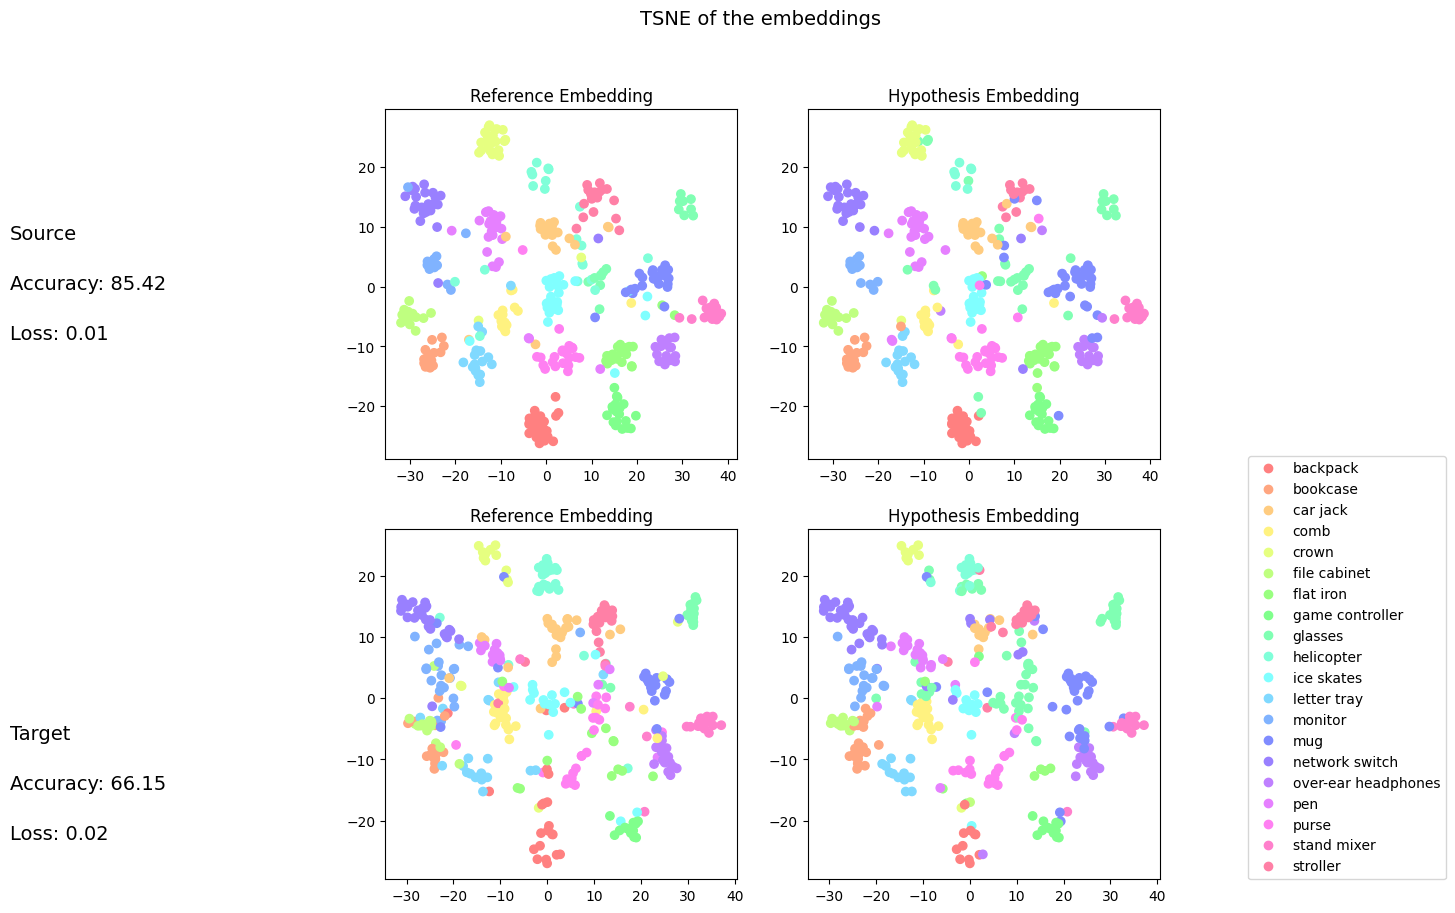

,precision,recall,f1-score,support
backpack,1.000000,0.920000,0.960000,26.000000
bookcase,0.940000,1.000000,0.970000,15.000000
car jack,0.950000,0.860000,0.900000,21.000000
comb,0.920000,0.860000,0.890000,14.000000
crown,1.000000,0.830000,0.900000,23.000000
file cabinet,1.000000,1.000000,1.000000,16.000000
flat iron,0.850000,0.890000,0.870000,19.000000
game controller,1.000000,0.890000,0.940000,19.000000
glasses,0.460000,1.000000,0.630000,16.000000
helicopter,1.000000,0.350000,0.520000,20.000000


In [ ]:
import colorsys
cost_function = get_ce_loss()
source_test_accuracy,target_test_accuracy,matrix_source,matrix_target,source_errors,target_errors = eval_plot_source_target(extractor,
                                                                                                                            classifier,
                                                                                                                            test_loader_realworld,
                                                                                                                            test_loader_product,
                                                                                                                            cost_function,
                                                                                                                            class_mapping,
                                                                                                                            layers=['identity'],
                                                                                                                            device='cuda:0')

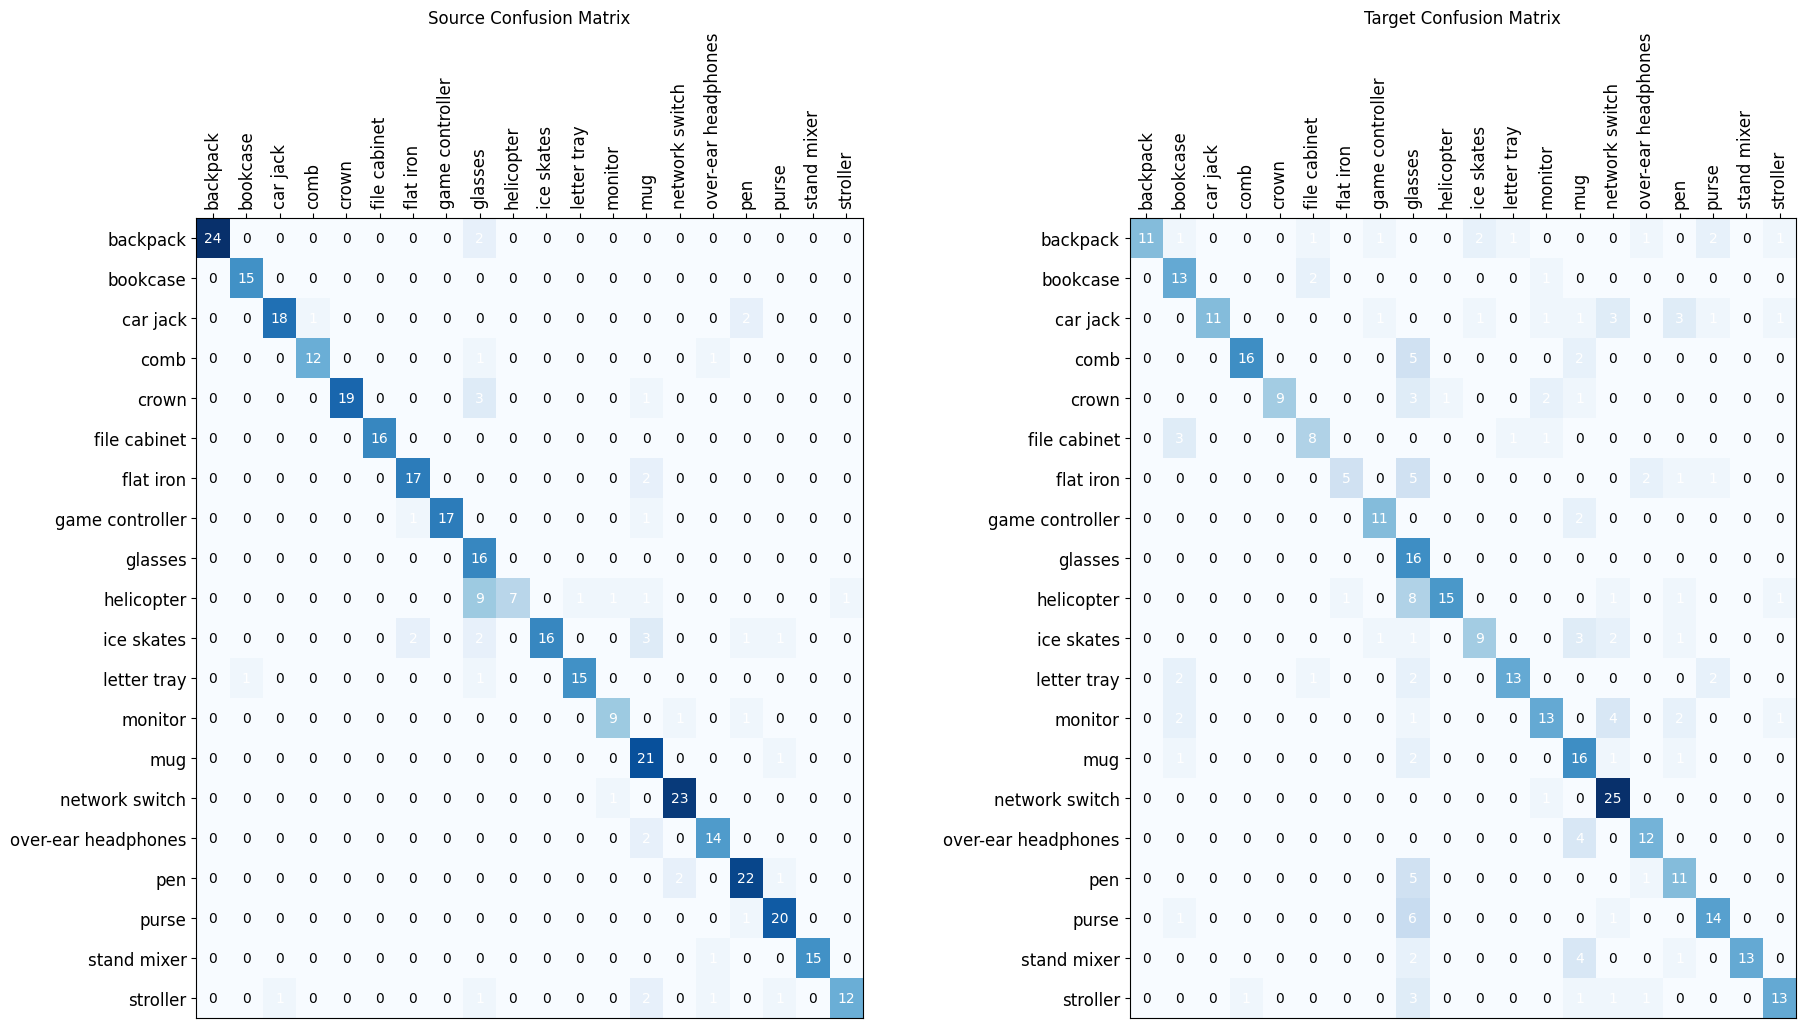

In [ ]:
confusion_matrix_plotter(matrix_source,matrix_target,class_mapping)

# Finetune ResNet18 on P only

Here we train a model of ResNet18 on product images only

In [ ]:
extractor = Extractor(models.resnet18(weights=True)).to('cuda:0')
classifier = Classifier(extractor.model[-2][1].bn2.num_features,n_classes=N_CLASSES).to(device)
init_weights(classifier)

optimizer_ex = get_optimizer(extractor,lr=LEARNING_RATE, wd=WEIGHT_DECAY)
optimizer_cl = get_optimizer(classifier,lr=LEARNING_RATE, wd=WEIGHT_DECAY)

ce_cost_function = get_ce_loss()

ex = train_source_only(extractor,
    classifier,
    train_loader_p,
    test_loader_p,
    ce_cost_function,
    optimizer_extractor = optimizer_ex,
    optimizer_classifier = optimizer_cl,
    epochs=EPOCHS,
    device=device)

Save

In [ ]:
# save pre trained fine tuned model
torch.save(extractor.state_dict(), resnet18_ex_r_path)
torch.save(classifier.state_dict(), resnet18_cl_r_path)
!cp $resnet18_ex_r_path $MODELS_BASEPATH
!cp $resnet18_cl_r_path $MODELS_BASEPATH

Load

In [ ]:
!cp $MODELS_BASEPATH$resnet18_ex_r_path  ./
!cp $MODELS_BASEPATH$resnet18_cl_r_path  ./
!echo $MODELS_BASEPATH$resnet18_ex_r_path
%%capture
extractor = Extractor(models.resnet18(weights=True)).to(device)
extractor.load_state_dict(torch.load(resnet18_ex_r_path))
extractor.to(device)
extractor.eval()
classifier = Classifier(extractor.model[-2][1].bn2.num_features,
                        n_classes=N_CLASSES,
                        layers=['identity'],).to(device)
classifier.load_state_dict(torch.load(resnet18_cl_r_path))
classifier.to(device)
classifier.eval()

### Test

Here we test the model and plot the TSNE embeddings of the features present in the last layer of the model (`avgpool`). We also plot the confusion matrixes and the images that the model classifies incorrectly. Ultimately we plot the mean confidence in prediction for each class.

In [ ]:
cost_function = get_ce_loss()
source_test_accuracy,target_test_accuracy,matrix_source,matrix_target,source_errors,target_errors = eval_plot_source_target(extractor,
                                                                                                                            classifier,
                                                                                                                            test_loader_r,
                                                                                                                            test_loader_p,
                                                                                                                            cost_function,
                                                                                                                            class_mapping,
                                                                                                                            layers=['identity'],
                                                                                                                            device='cuda:0')

In [ ]:
confusion_matrix_plotter(matrix_source,matrix_target,class_mapping)

# Coral attempt

Here we test the simple ResNET18 with a simple Domain adaptation strategy based on Correlation Alignment Loss.

It consists of the simple backbone trained with a joint loss of Cross Entropy and Correlation Alignment Loss

$L_{CORAL} = \frac{1}{4d^2}||C_S-C_T||_F^2$ where $||\cdot||_F^2$ is the squared Frobenius norm and $d$ is the dimensionality of the distributions. $C_S$ and $C_T$ are the covariance matrixes of source and target respectively

$\begin{aligned} \begin{aligned}&C_{S}= {\frac{1}{n_{S}-1}}({D_S^{\top } D_S - \frac{1}{n_{S}}{(\mathbf{1 }^{\top }D_S})^{\top }{(\mathbf{1 }^{\top }D_S})}) \end{aligned} \end{aligned}$
$\begin{aligned} \begin{aligned}&C_{T}= {\frac{1}{n_{T}-1}}({D_T^{\top } D_T - \frac{1}{n_{T}}{(\mathbf{1 }^{\top }D_T})^{\top }{(\mathbf{1 }^{\top }D_T})}) \end{aligned} \end{aligned}$

where $n_S$ and $n_T$ are the number of source and target elements in the dataset.

$L = CE + \lambda * L_{CORAL}$ where $\lambda$ is a weight


In [ ]:
# https://github.com/DenisDsh/PyTorch-Deep-CORAL/blob/master/coral.py
class CoralLoss(nn.Module):
    def __init__(self):
        super(CoralLoss,self).__init__()
    def forward(self,
                source: Tensor,
                target: Tensor ,
                source_labels: Iterable[int] = None,
                target_labels: Iterable[int] = None,
                classes: int = None,
                output_target_labels: Tensor = None) -> Tensor:
        d = source.size(1)  # dim vector
        source_c = self.compute_covariance(source)
        target_c = self.compute_covariance(target)
        loss = torch.sum(torch.mul((source_c - target_c), (source_c - target_c)))
        loss = loss / (4 * d * d)
        return loss

    def compute_covariance(self, input_data) -> Tensor:
        """
        Compute Covariance matrix of the input data
        """
        n = input_data.size(0)  # batch_size
        id_row = torch.ones(n).resize(1, n).to(device=device)
        sum_column = torch.mm(id_row, input_data)
        mean_column = torch.div(sum_column, n)
        term_mul_2 = torch.mm(mean_column.t(), mean_column)
        d_t_d = torch.mm(input_data.t(), input_data)
        c = torch.add(d_t_d, (-1 * term_mul_2)) * 1 / (n - 1)
        return c

def get_coral_loss():
    return CoralLoss()

### Finetune ResNet18 on R -> P

We train a model of ResNet18 on real life to product

In [ ]:
extractor = Extractor(models.resnet18(weights=True)).to(device)
classifier = Classifier(extractor.model[-2][1].bn2.num_features,n_classes=NUM_CLASSES,layers=['identity']).to(device)
init_weights(classifier)

optimizer_ex = get_optimizer(extractor,lr=0.00005, wd=0.000001)
optimizer_cl = get_optimizer(classifier,lr=0.0005, wd=0.000001)

ce_cost_function = get_ce_loss()
align_cost_function = get_coral_loss()

ex = train(
    extractor,
    classifier,
    source_train_loader = train_loader_realworld,
    source_test_loader = test_loader_realworld,
    target_train_loader = train_loader_product,
    target_test_loader = test_loader_product,
    ce_cost_function = ce_cost_function,
    align_cost_function = align_cost_function,
    optimizer_extractor = optimizer_ex,
    optimizer_classifier = optimizer_cl,
    epochs=EPOCHS,
    align_loss_weight = 1,
    layers = ['identity'],
    device=device)

# save pre trained fine tuned model
torch.save(extractor.state_dict(), resnet18_ex_coral_r_p_path)
torch.save(classifier.state_dict(), resnet18_cl_coral_r_p_path)

!cp $resnet18_ex_coral_r_p_path $MODELS_BASEPATH
!cp $resnet18_cl_coral_r_p_path $MODELS_BASEPATH

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning:

non-inplace resize is deprecated

{'CE Training loss': '0.00003', 'Align Training loss': '0.00018', 'Training accuracy': '100.00', 'Source Test loss': '0.00377', 'Source Test accuracy': '92.97', 'Target Test loss': '0.00564', 'Target Test accuracy': '91.67'}: 100%|██████████| 40/40 [1:31:12<00:00, 136.80s/it]

cp: missing file operand
Try 'cp --help' for more information.


cp: missing file operand
Try 'cp --help' for more information.


Load


In [ ]:
# load
%%capture
extractor = Extractor(models.resnet18(weights=True)).to(device)
extractor.load_state_dict(torch.load(resnet18_ex_coral_r_p_path))
extractor.to(device)
extractor.eval()
classifier = Classifier(extractor.model[-2][1].bn2.num_features,
                        n_classes=N_CLASSES,
                        layers=['identity'],).to(device)
classifier.load_state_dict(torch.load(resnet18_cl_coral_r_p_path))
classifier.to(device)
classifier.eval()

Test

In [ ]:
cost_function = get_ce_loss()
source_test_accuracy,target_test_accuracy,matrix_source,matrix_target,source_errors,target_errors = eval_plot_source_target(extractor,
                                                                                                                            classifier,
                                                                                                                            test_loader_r,
                                                                                                                            test_loader_p,
                                                                                                                            cost_function,
                                                                                                                            class_mapping,
                                                                                                                            layers=['identity'],
                                                                                                                            device='cuda:0')

In [ ]:
confusion_matrix_plotter(matrix_source,matrix_target,class_mapping)

### Finetune ResNet18 on P -> R

We train a model of ResNet18 on product images to real life

In [ ]:
extractor = Extractor(models.resnet18(weights=True)).to(device)
classifier = Classifier(extractor.model[-2][1].bn2.num_features,n_classes=N_CLASSES,layers=['identity']).to(device)
init_weights(classifier)

optimizer_ex = get_optimizer(extractor,lr=0.00005, wd=0.000001)
optimizer_cl = get_optimizer(classifier,lr=0.0005, wd=0.000001)

ce_cost_function = get_ce_loss()
align_cost_function = get_coral_loss()

ex = train(
    extractor,
    classifier,
    source_train_loader = train_loader_p,
    source_test_loader = test_loader_p,
    target_train_loader = train_loader_r,
    target_test_loader = test_loader_r,
    ce_cost_function = ce_cost_function,
    align_cost_function = align_cost_function,
    optimizer_extractor = optimizer_ex,
    optimizer_classifier = optimizer_cl,
    epochs=EPOCHS,
    align_loss_weight = 1,
    layers = ['identity'],
    device=device)

In [ ]:
# save pre trained fine tuned model
torch.save(extractor.state_dict(), resnet18_ex_coral_p_r_path)
torch.save(classifier.state_dict(), resnet18_cl_coral_p_r_path)
!cp $resnet18_ex_coral_p_r_path $MODELS_BASEPATH
!cp $resnet18_cl_coral_p_r_path $MODELS_BASEPATH

load

In [ ]:
!cp $MODELS_BASEPATH$resnet18_ex_coral_p_r_path  ./
!cp $MODELS_BASEPATH$resnet18_cl_coral_p_r_path  ./

# load
%%capture
extractor = Extractor(models.resnet18(weights=True)).to(device)
extractor.load_state_dict(torch.load(resnet18_ex_coral_p_r_path))
extractor.to(device)
extractor.eval()
classifier = Classifier(extractor.model[-2][1].bn2.num_features,
                        n_classes=N_CLASSES,
                        layers=['identity'],).to(device)
classifier.load_state_dict(torch.load(resnet18_cl_coral_p_r_path))
classifier.to(device)
classifier.eval()

test

In [ ]:
cost_function = get_ce_loss()
source_test_accuracy,target_test_accuracy,matrix_source,matrix_target,source_errors,target_errors = eval_plot_source_target(extractor,
                                                                                                                            classifier,
                                                                                                                            test_loader_p,
                                                                                                                            test_loader_r,
                                                                                                                            cost_function,
                                                                                                                            class_mapping,
                                                                                                                            layers=['identity'],
                                                                                                                            device='cuda:0')